In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import xarray
import seaborn as sns
from scipy import stats

In [2]:
energy = pd.read_csv('Downloads/CHALLHWF.csv')
energy

,SETTLEMENTDATE,CHALLHWF
0,2014-01-01 00:00:00,20.799999
1,2014-01-01 00:05:00,18.799999
2,2014-01-01 00:10:00,18.000000
3,2014-01-01 00:15:00,16.200001
4,2014-01-01 00:20:00,14.299999
...,...,...
835605,2021-12-31 23:35:00,11.200000
835606,2021-12-31 23:40:00,12.100000
835607,2021-12-31 23:45:00,10.400000
835608,2021-12-31 23:50:00,10.000000


Challicum Hills coordinates: 37.38°S 143.11°E <br>
Challicum Hills gridpoints: (10, 20)

In [3]:
energy.iloc[:,0] = pd.to_datetime(energy.iloc[:,0], infer_datetime_format = True)
energy = energy.set_index("SETTLEMENTDATE")
energy_2018 = energy.loc[datetime(2017,12,31,6,0,0):datetime(2018,12,31,5,30,0)]
energy_night = ~((energy.index.hour>=12) & (energy.index.hour<0))

/local/v46/lh2344/tmp/ipykernel_3348497/3512016631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_2018['minutes'] = energy_2018.index.minute
/local/v46/lh2344/tmp/ipykernel_3348497/3512016631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_2018['hour'] = energy_2018.index.hour


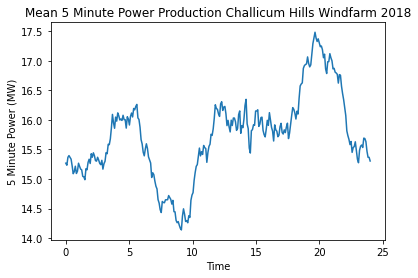

In [4]:
energy_2018['minutes'] = energy_2018.index.minute
energy_2018['hour'] = energy_2018.index.hour
mean_hourly = energy_2018.groupby(['hour', 'minutes']).mean()

plt.plot(np.linspace(0,24,12*24),mean_hourly.iloc[:,0])
plt.xlabel('Time')
plt.ylabel('5 Minute Power (MW)')
plt.title('Mean 5 Minute Power Production Challicum Hills Windfarm 2018')
plt.savefig('Challicum 5 min power')

In [5]:
mean_hourly.max()
plt.plot(np.arange(0,24,1/12),hourly_mean_nonjetnight.iloc[:,1])

NameError: name 'hourly_mean_nonjetnight' is not defined

In [6]:
gridpoints = 2
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnightsv3')
jetnight2 = xarray.DataArray(jetnight.jetnight2_v3, dims = ['time','latitude','longitude'])
jetnight2 = jetnight2.isel(latitude = slice(10-gridpoints,10+gridpoints), longitude = slice(20-gridpoints,20+gridpoints))

t = np.arange(datetime(2017,12,31,6,0,0), datetime(2018,12,31,6,0,0), timedelta(days=1)).astype(datetime)
jetnight2['time'] = t
jetnight2_2018 = jetnight2
jetnight_true = jetnight2_2018.sum(dim = ['latitude', 'longitude']) > 0
print(jetnight_true.sum().data)

45


In [7]:
# On a jetnight an array is created so that every half hour timestep within a jetnight is defined at 'True' and
# 'False' otherwise
jethour_true = np.empty(365*288)
for day in range(0,365):
    daystart = day*288
    dayend = (day*288)+288
    for hour in range(daystart,dayend):
        jethour_true[hour] = jetnight_true[day]
jethour_true.sum()
jethour_true = np.array(jethour_true, dtype = bool)

In [8]:
days = np.arange(datetime(2018,1,1), datetime(2019,1,1), timedelta(days=1)).astype(datetime)
jetnight_true1 = pd.DataFrame([days,jetnight_true.to_numpy()])#, columns = ['Day','Jetnight?'])
jetnight_truedf = pd.DataFrame(jetnight_true1.T)#, columns = ['Day','Jetnight?'])
#jetnight_truedf = jetnight_truedf.iloc[:,0].reset_index()
jetnight_truedf.rename(columns = {0:"Date", 1: "Jetnight?"})

,Date,Jetnight?
0,2018-01-01,False
1,2018-01-02,False
2,2018-01-03,False
3,2018-01-04,False
4,2018-01-05,True
...,...,...
360,2018-12-27,True
361,2018-12-28,False
362,2018-12-29,False
363,2018-12-30,False


In [9]:
# Time stamp is turned into the index
energy_2018

,CHALLHWF,minutes,hour
SETTLEMENTDATE,,,
2017-12-31 06:00:00,0.000000,0,6
2017-12-31 06:05:00,0.000000,5,6
2017-12-31 06:10:00,0.000000,10,6
2017-12-31 06:15:00,0.000000,15,6
2017-12-31 06:20:00,0.000000,20,6
...,...,...,...
2018-12-31 05:10:00,17.799999,10,5
2018-12-31 05:15:00,16.900000,15,5
2018-12-31 05:20:00,16.000000,20,5


In [10]:
start = datetime(2017,12,31,6,0,0)
end = datetime(2018,12,31,5,55,0)

newindex = pd.date_range(start, end, freq = '5T')
energy_2018 = energy_2018.reindex(newindex)

In [11]:
energy_2018_jetnight = energy_2018[jethour_true].reset_index().rename(columns={"index":"SETTLEMENTDATE"})
energy_2018_nonjetnight = energy_2018[~jethour_true].reset_index().rename(columns={"index":"SETTLEMENTDATE"})

In [12]:
energy_2018_jetnight['SETTLEMENTDATE'] = pd.to_datetime(energy_2018_jetnight['SETTLEMENTDATE'])
energy_2018_jetnight['minutes'] = energy_2018_jetnight['SETTLEMENTDATE'].apply(lambda x: x.minute)
energy_2018_jetnight['hour'] = energy_2018_jetnight['SETTLEMENTDATE'].apply(lambda x: x.hour)

energy_2018_nonjetnight['SETTLEMENTDATE'] = pd.to_datetime(energy_2018_nonjetnight['SETTLEMENTDATE'])
energy_2018_nonjetnight['minutes'] = energy_2018_nonjetnight['SETTLEMENTDATE'].apply(lambda x: x.minute)
energy_2018_nonjetnight['hour'] = energy_2018_nonjetnight['SETTLEMENTDATE'].apply(lambda x: x.hour)

In [13]:
jetnight_true.resample(time="1M").sum()

<xarray.DataArray 'jetnight2_v3' (time: 13)>
array([0, 8, 8, 4, 5, 0, 0, 0, 0, 4, 5, 3, 8])
Coordinates:
  * time     (time) datetime64[ns] 2017-12-31 2018-01-31 ... 2018-12-31

In [14]:
hourly_mean_jetnight = energy_2018_jetnight.groupby(['hour', 'minutes']).mean().reset_index()
hourly_mean_jetnight['minutes'] = np.arange(0,24,1/12)
hourly_mean_jetnight = hourly_mean_jetnight.drop(columns = ['hour'])

hourly_mean_nonjetnight = energy_2018_nonjetnight.groupby(['hour', 'minutes']).mean().reset_index()
hourly_mean_nonjetnight['minutes'] = np.arange(0,24,1/12)
hourly_mean_nonjetnight = hourly_mean_nonjetnight.drop(columns = ['hour'])

In [15]:
elecjn_2018 = energy_2018_jetnight.iloc[:,1] # Actual electricity produced at each half hour through 2018
elecnonjn_2018 = energy_2018_nonjetnight.iloc[:,1]

elecjn_2018np = elecjn_2018.to_numpy().reshape(jetnight_true.sum().data,12*24)
elecnonjn_2018np = elecnonjn_2018.to_numpy().reshape((365-jetnight_true.sum().data),12*24)

In [16]:
# Loops for reorganising 5 minute power data into 30 minute energy data (for comparison purposes to Coonooer bridge)
thirty_min_energyjn = np.empty([np.shape(elecjn_2018np)[0],48])
for day in range(0,np.shape(elecjn_2018np)[0]):
    for minute in range(0,48):
        minstart = minute*6 # first 30 mins, second 30 mins etc...
        minend = (minute*6) + 6
        thirty_minjn = np.empty(6)
        for index, t in enumerate(range(minstart, minend)):
            thirty_minjn[index] = elecjn_2018np[day,t]
        thirty_min_energyjn[day,minute] = thirty_minjn.mean()*0.5 # mean of each 30 min period & convert to MWh

thirty_min_energynonjn = np.empty([np.shape(elecnonjn_2018np)[0],48])
for day in range(0,np.shape(elecnonjn_2018np)[0]):
    for minute in range(0,48):
        minstart = minute*6
        minend = (minute*6) + 6
        thirty_min_nonjn = np.empty(6)
        for index, t in enumerate(range(minstart, minend)):
            thirty_min_nonjn[index] = elecnonjn_2018np[day,t]
        thirty_min_energynonjn[day,minute] = thirty_min_nonjn.mean()*0.5 # Convert to MWh for 0.5 hours

In [17]:
# Filter data using np.isnan
mask = ~np.isnan(thirty_min_energyjn)
elecjn_filter = [d[m] for d, m in zip(thirty_min_energyjn.T, mask.T)]
print(np.shape(elecjn_filter))

mask = ~np.isnan(thirty_min_energynonjn)
elecnonjn_filter = [d[m] for d, m in zip(thirty_min_energynonjn.T, mask.T)]
print(np.shape(elecnonjn_filter))

(48,)
(48,)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


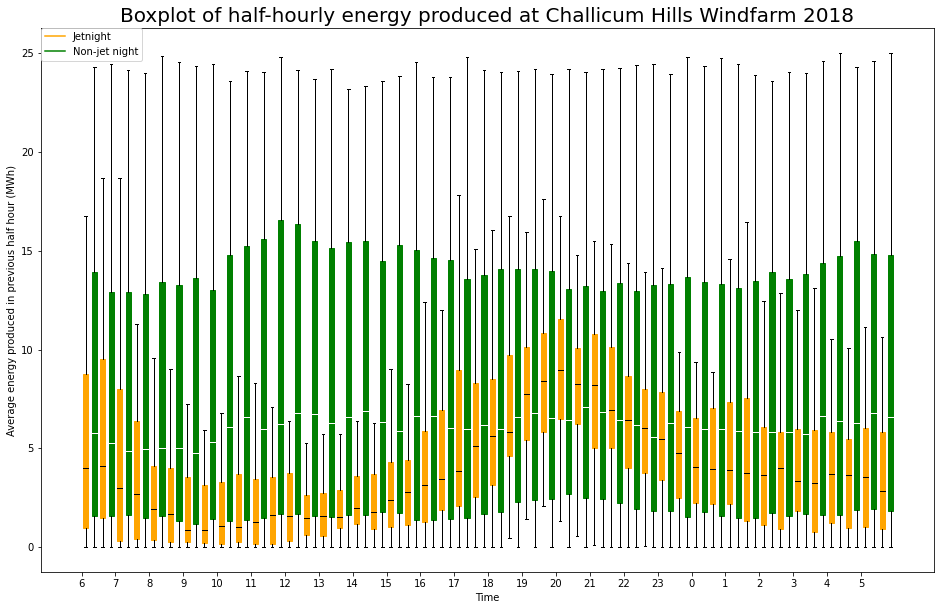

In [19]:
# Filter data using np.isnan
plt.figure(figsize = (16,10))
plt.boxplot(elecjn_filter, manage_ticks = False, showfliers = False, 
            positions = np.arange(0.25, 48.25, 1), widths = 0.3, patch_artist = True, 
            boxprops=dict(facecolor='orange', color='orange'),  medianprops=dict(color='black'))
plt.xlabel('Time')
plt.ylabel('Energy in previous half hour (MWh)')
plt.title('Boxplot of half-hourly energy produced Coonooer Bridge Windfarm 2018 (Jetnights)')
plt.xticks(np.arange(0,50,2), labels = np.arange(0,25,1))
#plt.show()
#plt.savefig('Jetnight energy boxplot')

plt.boxplot(elecnonjn_filter, manage_ticks = False, showfliers = False, 
            positions = np.arange(0.75, 48.75, 1), widths = 0.3, patch_artist = True, 
            boxprops=dict(facecolor='green', color='green'),  medianprops=dict(color='white'))
plt.xlabel('Time')
plt.ylabel('Average energy produced in previous half hour (MWh)')
plt.title('Boxplot of half-hourly energy produced at Challicum Hills Windfarm 2018', fontsize = 20)
xticks = np.concatenate([np.arange(6,24),np.arange(0,6)])
plt.xticks(np.arange(0,48,2), labels = xticks)

hY, = plt.plot([0,1],'orange')
hG, = plt.plot([0,10],'green')
plt.legend((hY, hG),('Jetnight', 'Non-jet night'), loc = [0,0.94])
hY.set_visible(False)
hG.set_visible(False)

plt.savefig('Challicum Hills boxplot')

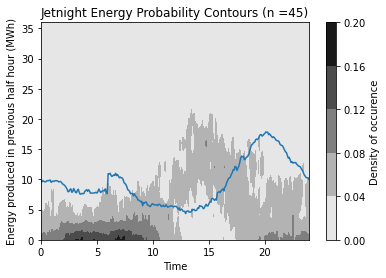

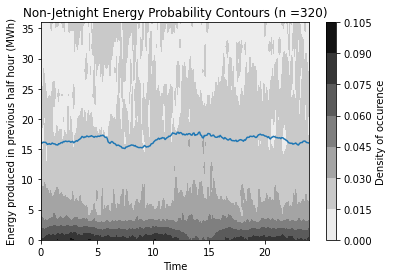

In [63]:
bins = 40 # Highest y-value (energy production)
histjn = np.empty([12*24,10])
histnonjn = np.empty([12*24,10])


for i in range(0,12*24): # produces number of values at each energy interval from 1-12
    histjn[i,:],_ = np.histogram(elecjn_2018np[:,i], bins = np.arange(0,bins+1,4), density = True)
    histnonjn[i,:],_ = np.histogram(elecnonjn_2018np[:,i], bins = np.arange(0,bins+1,4), density = True)

#hist.T
plt.contourf(np.arange(0,24,1/12), np.arange(0,bins,4), histjn.T, 5, cmap = 'binary') # histogram transposed so contour function reads it as columns rather than rows
plt.plot(hourly_mean_jetnight.iloc[:,0],hourly_mean_jetnight.iloc[:,1], label = 'Jetnight')
plt.colorbar(label = 'Density of occurence')
plt.title('Jetnight Energy Probability Contours (n ='+str(jetnight_true.sum().data)+')')
plt.ylabel('Energy produced in previous half hour (MWh)')
plt.xlabel('Time')
plt.show()

plt.contourf(np.arange(0,24,1/12), np.arange(0,bins,4), histnonjn.T, 5, cmap = 'binary')
plt.plot(hourly_mean_nonjetnight.iloc[:,0],hourly_mean_nonjetnight.iloc[:,1], label = 'Non-Jetnight')
plt.colorbar(label = 'Density of occurence')
plt.title('Non-Jetnight Energy Probability Contours (n ='+str(365-jetnight_true.sum().data)+')')
plt.ylabel('Energy produced in previous half hour (MWh)')
plt.xlabel('Time')
plt.show()


In [64]:
# Double checking contour graph makes sense
density, _ = np.histogram(elecnonjn_2018np[:,140], bins = np.arange(0,40), density = False)
_, values = np.histogram(elecnonjn_2018np[:,140], bins = np.arange(0,40), density = False)
print(density)
print(values)
print(stats.describe(elecnonjn_2018np[:,140], nan_policy = 'omit'))

[54 11 12 15 12  9 13  8  7  7  3  7  3  8  9 12  5  4  3  2  4  4  5  4
  4  3  7  5  5  2  1  4  3  4  1  4  3  4  7]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
DescribeResult(nobs=320, minmax=(0.0, 49.800003), mean=16.451874975, variance=225.70958828724224, skewness=0.6152007051518128, kurtosis=-0.9889439322447204)


### 2 sample statistical tests 

In [65]:
from statsmodels.stats.weightstats import ztest as ztest

z_score = np.empty(12*24)
p_value = np.empty(12*24)
for i in range(0,12*24):
    filtjn, filtnonjn = ~np.isnan(elecjn_2018np[:,i]), ~np.isnan(elecnonjn_2018np[:,i]) # removes nans before passing through significance test
    z_score[i], p_value[i] = ztest(elecjn_2018np[:,i][filtjn], elecnonjn_2018np[:,i][filtnonjn], value = 0)


significant = p_value < 0.05
significant

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

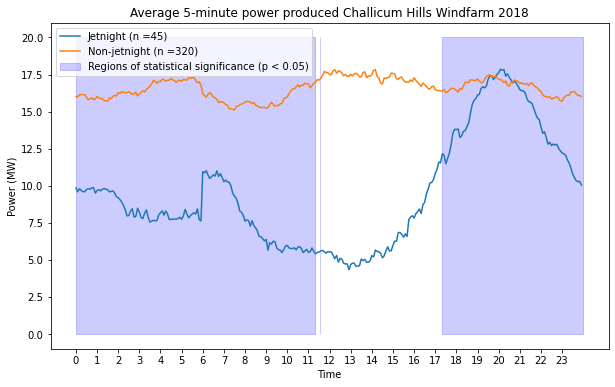

In [66]:
plt.figure(figsize = [10,6])
plt.plot(hourly_mean_jetnight.iloc[:,0],hourly_mean_jetnight.iloc[:,1], 
         label = 'Jetnight (n ='+str(jetnight_true.sum().data)+')')
plt.plot(hourly_mean_nonjetnight.iloc[:,0],hourly_mean_nonjetnight.iloc[:,1], 
         label = 'Non-jetnight (n ='+str(365-jetnight_true.sum().data)+')')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Average 5-minute power produced Challicum Hills Windfarm 2018')
plt.xticks(np.arange(0,24))
plt.fill_between(np.linspace(0,24,12*24),0,20, where = significant,
                 facecolor="blue", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2, label = 'Regions of statistical significance (p < 0.05)')   

plt.legend()
plt.savefig('Challicum Hills power jetnights')

# To do if you want to include Challicum/Ararat Ramping:
Create a energy_2018 variable as in Coonooer Bridge, with all of 2018 energy reorganised into 30 minute average energy

In [22]:
energy_2018np = energy_2018.iloc[:,0].to_numpy()
energy_2018np = energy_2018np.reshape(365,288)

In [23]:
thirty_min_energy = np.empty([np.shape(energy_2018np)[0],48])
for day in range(0,np.shape(energy_2018np)[0]):
    for minute in range(0,48):
        minstart = minute*6 # first 30 mins, second 30 mins etc...
        minend = (minute*6) + 6
        thirty_min = np.empty(6)
        for index, t in enumerate(range(minstart, minend)):
            thirty_min[index] = energy_2018np[day,t]
        thirty_min_energy[day,minute] = thirty_min.mean()*0.5 # mean of each 30 min period & convert to MWh
        


In [24]:
# Find percentage ramping events
energy_2018_np = thirty_min_energy.reshape(-1,1)

percent_ramp = np.empty(len(energy_2018_np)-1)
for i in range(0,len(energy_2018_np)-1):
    if energy_2018_np[i] <= 0:
        percent_ramp[i] = np.nan
    else: percent_ramp[i] = ((energy_2018_np[i+1] - energy_2018_np[i]) / energy_2018_np[i]) * 100


In [25]:
percent_ramp.shape

(17519,)

In [26]:
start = datetime(2017,12,31,6,30,0)
end = datetime(2018,12,31,5,30,0)

percent_ramp_time = xarray.DataArray(percent_ramp, coords = {"time": pd.date_range(start,end, freq = "30min")})
percent_ramp_time_evening = xarray.DataArray(
    np.empty(len(percent_ramp)), coords = {"time": pd.date_range(start,end, freq = "30min")})

for i in range(len(percent_ramp_time)):
    if 17 <= percent_ramp_time[i].time.dt.hour <= 21:
        percent_ramp_time_evening[i] = percent_ramp_time[i]
    
    else: percent_ramp_time_evening[i] = np.nan

([<matplotlib.axis.XTick at 0x7f6bbdd17ee0>,
 [Text(1, 0, 'January'),
  Text(2, 0, 'February'),
  Text(3, 0, 'March'),
  Text(4, 0, 'April'),
  Text(5, 0, 'May'),
  Text(6, 0, 'June'),
  Text(7, 0, 'July'),
  Text(8, 0, 'August'),
  Text(9, 0, 'September'),
  Text(10, 0, 'October'),
  Text(11, 0, 'November'),
  Text(12, 0, 'December')])

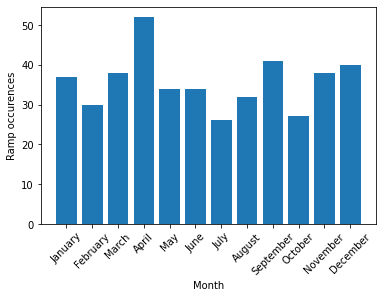

In [27]:
ramp = percent_ramp_time_evening > 50
ramps_by_month = ramp.groupby(ramp.time.dt.month).sum()

plt.bar(ramps_by_month.month, ramps_by_month)
plt.xlabel('Month')
plt.ylabel('Ramp occurences')
plt.xticks(ramps_by_month.month, pd.date_range(datetime(2018,1,1), datetime(2018,12,31), freq = 'M').strftime("%B"), rotation = 45)

In [ ]:
# #jethour_true1 = np.delete(jethour_true, 0)
# jetnight_ramps = percent_ramp[jethour_true1]
# nonjetnight_ramps = percent_ramp[~jethour_true1]

In [ ]:
# print('jethour_true length', len(jethour_true))
# print('percent_ramp length', len(percent_ramp))
# print('jethour_true1 length', len(jethour_true1))

In [ ]:
# jetnightramp_proportion = np.empty(15)
# for index, i in enumerate(np.arange(0,150,10)):
#     ramp_all = percent_ramp >= i
#     ramp_jetnight = jetnight_ramps >= i
#     jetnightramp_proportion[index] = (ramp_jetnight.sum())*100/(ramp_all.sum())
    
# plt.bar(np.arange(0,150,10), abs(jetnightramp_proportion), width = 8)
# plt.title('Percentage of ramps of more than x% occuring on jetnights')
# plt.ylabel('Percentage occuring on jetnights')
# plt.xlabel('Change in power production from previous half hour (%)')

# jetnights_proportion = (jethour_true.sum()*100)/len(jethour_true)
# print('Percentage jetnights of all nights', jetnights_proportion, '%')

# plt.plot([0,150], [jetnights_proportion,jetnights_proportion], color = 'red', label = 'Jetnights % of all nights')
# plt.legend()
# plt.savefig('Percentage jetnights of all nights')

In [ ]:
# plt.hist(abs(nonjetnight_ramps), bins = np.arange(0,140,20), density = False, label = 'Non Jetnight ramps')
# plt.title('Histogram of ramping events at Coonooer Bridge')
# plt.ylabel('Frequency')
# plt.xlabel('Absolute percentage change in energy production from previous half hour')

# plt.hist(abs(jetnight_ramps), bins = np.arange(0,140,20), density = False, alpha = 0.5, label = 'Jetnight ramps')
# plt.title('Histogram of ramping events at Coonooer Bridge')
# plt.ylabel('Probability')
# plt.xlabel('Absolute percentage change in energy production from previous half hour')

# plt.legend()
# plt.yscale('log')
# plt.savefig('Histogram of ramping events at Coonooer Bridge')

In [ ]:
# # Checking for statistics regarding proportion of large rampings in jetnights vs non jetnights
# jetnight_20, _ = np.histogram(abs(jetnight_ramps), bins = np.arange(0,140,20)) # In 20% intervals
# nonjetnight_20, _ = np.histogram(abs(nonjetnight_ramps), bins = np.arange(0,140,20))
# n = 2
# jetnight_20[n:].sum()/(jetnight_20[n:].sum() + nonjetnight_20[n:].sum())
